给定多个一维数据点，用不同结构的神经网络和超参数训练，画图显示每一种设定下的拟合结果

* 模型：网络层数，每层宽度，激活函数（需要写出表达式）
* 策略：损失函数（需要写出表达式），正则化项（可以没有）
* 优化：优化算法（GD，SGD，Adam），学习率，网络参数的初始化（W和b的分布，均值，方差），epoch数量

每次实验画出：

* 所有数据点+网络初始函数曲线+训练结束后输出的函数曲线
* 损失轨迹图（Loss vs Epoch）

需要10组不同参数的实验，每组做4次

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import os
import shutil

plt.rcParams['font.sans-serif'] = ['simhei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False   #用来正常显示负号

: 

In [2]:
# 生成待拟合的一维数据点
x = np.linspace(-1, 1, 100)

# 可以选择拟合一个复杂多项式函数还是一个简单函数
func = lambda x: 4.5*(x**5) + 8.5*(x**3) - 4*(x**2) -3*x
# func = lambda x: 4.5*x + 2
# func = lambda x: -4*(x**2) + 4.5*x + 2

rng = np.random.RandomState(2)
noise = rng.normal(loc=0, scale=.5, size=x.shape)
y = func(x)

In [3]:
# 把x和y的值归一化道0到1的范围内
scale_x = MinMaxScaler()
x_scaled = scale_x.fit_transform(x.reshape(-1, 1))
scale_y = MinMaxScaler()
y_scaled = scale_y.fit_transform(y.reshape(-1, 1))

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: simhei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: simhei


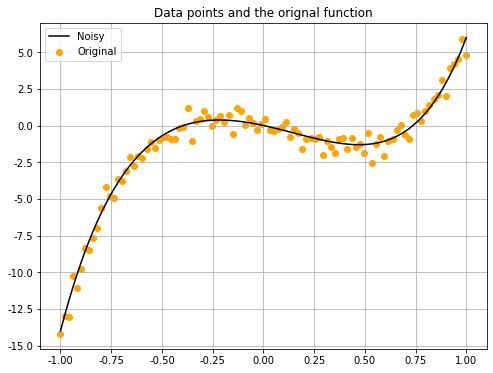

In [4]:
# 绘制数据点和原函数曲线
plt.figure(figsize=(8, 6))
plt.scatter(x, y+noise, label='OriginalNoisy', color='orange')
plt.plot(x, y, label='Original', color='black')
plt.title('Data points and the orignal function')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
def build_linear(in_feat=1, out_feat=1, act='relu', init='normal'):
    # 构建一层线性层
    linear = nn.Linear(in_feat, out_feat)
    # 设置权重初始化
    nn.init.normal_(linear.weight, mean=0.0, std=1.0)
    nn.init.constant_(linear.bias, val=0)
    # 设置激活函数
    if act is None:
        return linear
    if act == 'relu':
        act_func = nn.ReLU()
    elif act == 'sigmoid':
        act_func = nn.Sigmoid()
    elif act == 'tanh':
        act_func = nn.Tanh()
    else:
        raise ValueError('Invalid act')
    res = nn.Sequential(linear, act_func)
    return res

In [6]:
def build_nn(hidden_units=[1, 2, 2, 1], act='relu', init='normal'):
    # 构建神经网络模型
    assert len(hidden_units) >= 2 #输入层和输出层
    layers = []
    for i in range(len(hidden_units)-1):
        if i == len(hidden_units)-2:
            act = None # 最后一层不用激活函数
        layers.append(build_linear(hidden_units[i], hidden_units[i+1], act, init))
    res = nn.Sequential(*layers)
    return res

In [7]:
def build_optim(optim, param, lr):
    # 构建优化器
    opt = None
    if optim == 'sgd':
        opt = torch.optim.SGD(param, lr=lr)
    elif optim == 'adam':
        opt = torch.optim.Adam(param, lr=lr)
    elif optim == 'rmsprop':
        opt = torch.optim.RMSprop(param, lr=lr)
    else:
        raise ValueError("Invalid optim")
    return opt

In [8]:
def build_loss(loss):
    # 构建损失函数
    if loss == 'mse':
        return nn.MSELoss(reduction='sum')
    else:
        raise ValueError('Invalid loss type')

In [9]:
def build_loader(x, y, batch_size):
    # 构建数据加载器
    count = x.shape[0]
    x = torch.tensor(x).view(count, 1).float()
    y = torch.tensor(y).view(count, 1).float()
    ds = TensorDataset(x, y)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    return loader

In [10]:
# 10种配置
configs = dict()

In [11]:
# 参数设置
# 这个设置只有一个神经元，相当于一个线性分类器
configs['config1'] = dict(
    hidden_units = [1, 1],
    act = 'sigmoid',
    init = 'normal',
    loss = 'mse',
    reg = None,
    optim = 'rmsprop',
    lr = 1e-3,
    epochs = 3000,
    imgdir = 'config1'
)

In [12]:
# 参数设置
# 添加一层神经网络
configs['config2'] = dict(
    hidden_units = [1, 2, 1],
    act = 'sigmoid',
    init = 'normal',
    loss = 'mse',
    reg = None,
    optim = 'rmsprop',
    lr = 1e-3,
    epochs = 2000,
    imgdir = 'config2'
)

In [13]:
# 参数设置
# 增加隐藏层神经元宽度到4
configs['config3'] = dict(
    hidden_units = [1, 4, 1],
    act = 'sigmoid',
    init = 'normal',
    loss = 'mse',
    reg = None,
    optim = 'rmsprop',
    lr = 1e-3,
    epochs = 2000,
    imgdir = 'config3'
)

In [14]:
# 参数设置
# 增加隐藏层神经元宽度到8
configs['config4'] = dict(
    hidden_units = [1, 8, 1],
    act = 'sigmoid',
    init = 'normal',
    loss = 'mse',
    reg = None,
    optim = 'rmsprop',
    lr = 1e-3,
    epochs = 2000,
    imgdir = 'config4'
)

In [15]:
# 参数设置
# 增加神经网络的深度到2
configs['config5'] = dict(
    hidden_units = [1, 8, 8, 1],
    act = 'sigmoid',
    init = 'normal',
    loss = 'mse',
    reg = None,
    optim = 'rmsprop',
    lr = 1e-3,
    epochs = 2000,
    imgdir = 'config5'
)

In [16]:
# 参数设置
# 增加神经网络的深度到3
configs['config6'] = dict(
    hidden_units = [1, 8, 8, 8, 1],
    act = 'sigmoid',
    init = 'normal',
    loss = 'mse',
    reg = None,
    optim = 'rmsprop',
    lr = 1e-3,
    epochs = 2000,
    imgdir = 'config6'
)

In [17]:
# 参数设置
# 增加神经网络的宽度到32
configs['config7'] = dict(
    hidden_units = [1, 32, 32, 32, 1],
    act = 'sigmoid',
    init = 'normal',
    loss = 'mse',
    reg = None,
    optim = 'rmsprop',
    lr = 1e-3,
    epochs = 2000,
    imgdir = 'config7'
)

In [18]:
# 参数设置
# 一个非常深的神经网络和ReLU激活函数
configs['config8'] = dict(
    hidden_units = [1] + [16]*10 + [1],  #[1, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1]
    act = 'relu',
    init = 'normal',
    loss = 'mse',
    reg = None,
    optim = 'rmsprop',
    lr = 1e-3,
    epochs = 2000,
    imgdir = 'config8'
)

In [19]:
# 参数设置
# 使用 rmsprop 优化器
configs['config9'] = dict(
    hidden_units = [1, 128, 128, 128, 1],
    act = 'sigmoid',
    init = 'normal',
    loss = 'mse',
    reg = None,
    optim = 'rmsprop',
    lr = 1e-3,
    epochs = 2000,
    imgdir = 'config9'
)

In [20]:
# 参数设置
# 使用 adam 优化器
configs['config10'] = dict(
    hidden_units = [1, 128, 128, 128, 1],
    act = 'sigmoid',
    init = 'normal',
    loss = 'mse',
    reg = None,
    optim = 'adam',
    lr = 1e-3,
    epochs = 2000,
    imgdir = 'config10'
)

In [ ]:
# 做4组实验
for t in range(1, 1+4):
    print("第{}次实验".format(t))
    for k, config in configs.items():
        print("配置参数类型{}".format(k))
        print(config)
        # 使用之前写好的函数创建模型，优化器，损失函数和数据加载器
        model = build_nn(hidden_units=config['hidden_units'], act=config['act'], init=config['init'])

        opt = build_optim(config['optim'], model.parameters(), config['lr'])

        loss_fn = build_loss(config['loss'])

        loader = build_loader(x_scaled, y_scaled, x_scaled.shape[0])

        # 训练神经网络模型
        loss_hist = []
        for epoch in range(config['epochs']):
            for i, (inp, tgt) in enumerate(loader):
                out = model(inp)
                loss = loss_fn(out, tgt)
                opt.zero_grad()
                loss.backward()
                opt.step()
                # print(f'loss: {loss.item()}')
            loss_hist.append(loss.item())

        # 绘制loss-epoch曲线
        plt.figure(figsize=(8, 6))
        plt.plot(loss_hist, color='green')
        plt.xlabel('loss')
        plt.ylabel('epoch')
        plt.grid(True)
        plt.title('Loss history')
        os.makedirs(config['imgdir'], exist_ok=True)
        plt.savefig('{}/loss_hist.svg'.format(config['imgdir']))
        #plt.show()

        # 使用训练好的模型预测结果
        with torch.no_grad():
            preds = model(torch.tensor(x_scaled).float())
        preds = preds.numpy()
        preds = scale_y.inverse_transform(preds)

        # 绘制数据点和原函数曲线
        plt.figure(figsize=(8, 6))
        plt.scatter(x, y+noise, label='Original', color='orange')
        plt.plot(x, y, label='Noisy', color='black')
        plt.plot(x, preds, label='Prediction', color='blue')
        plt.title('Data points, the orignal function, and the prediction')
        plt.legend()
        plt.grid(True)
        plt.savefig('{}/fit_curve.svg'.format(config['imgdir']))
        #plt.show()
    os.makedirs('exp{}'.format(t))
    for k in configs:
        shutil.move(k, 'exp{}/'.format(t))

第1次实验
    配置参数类型config1
{'hidden_units': [1, 1], 'act': 'sigmoid', 'init': 'normal', 'loss': 'mse', 'reg': None, 'optim': 'rmsprop', 'lr': 0.001, 'epochs': 3000, 'imgdir': 'config1'}
    配置参数类型config2
{'hidden_units': [1, 2, 1], 'act': 'sigmoid', 'init': 'normal', 'loss': 'mse', 'reg': None, 'optim': 'rmsprop', 'lr': 0.001, 'epochs': 2000, 'imgdir': 'config2'}
    配置参数类型config3
{'hidden_units': [1, 4, 1], 'act': 'sigmoid', 'init': 'normal', 'loss': 'mse', 'reg': None, 'optim': 'rmsprop', 'lr': 0.001, 'epochs': 2000, 'imgdir': 'config3'}
    配置参数类型config4
{'hidden_units': [1, 8, 1], 'act': 'sigmoid', 'init': 'normal', 'loss': 'mse', 'reg': None, 'optim': 'rmsprop', 'lr': 0.001, 'epochs': 2000, 'imgdir': 'config4'}
    配置参数类型config5
{'hidden_units': [1, 8, 8, 1], 'act': 'sigmoid', 'init': 'normal', 'loss': 'mse', 'reg': None, 'optim': 'rmsprop', 'lr': 0.001, 'epochs': 2000, 'imgdir': 'config5'}
    配置参数类型config6
{'hidden_units': [1, 8, 8, 8, 1], 'act': 'sigmoid', 'init': 'normal', 'loss'

/home/lab2033/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


    配置参数类型config2
{'hidden_units': [1, 2, 1], 'act': 'sigmoid', 'init': 'normal', 'loss': 'mse', 'reg': None, 'optim': 'rmsprop', 'lr': 0.001, 'epochs': 2000, 'imgdir': 'config2'}
    配置参数类型config3
{'hidden_units': [1, 4, 1], 'act': 'sigmoid', 'init': 'normal', 'loss': 'mse', 'reg': None, 'optim': 'rmsprop', 'lr': 0.001, 'epochs': 2000, 'imgdir': 'config3'}
    配置参数类型config4
{'hidden_units': [1, 8, 1], 'act': 'sigmoid', 'init': 'normal', 'loss': 'mse', 'reg': None, 'optim': 'rmsprop', 'lr': 0.001, 'epochs': 2000, 'imgdir': 'config4'}
    配置参数类型config5
{'hidden_units': [1, 8, 8, 1], 'act': 'sigmoid', 'init': 'normal', 'loss': 'mse', 'reg': None, 'optim': 'rmsprop', 'lr': 0.001, 'epochs': 2000, 'imgdir': 'config5'}
    配置参数类型config6
{'hidden_units': [1, 8, 8, 8, 1], 'act': 'sigmoid', 'init': 'normal', 'loss': 'mse', 'reg': None, 'optim': 'rmsprop', 'lr': 0.001, 'epochs': 2000, 'imgdir': 'config6'}
    配置参数类型config7
{'hidden_units': [1, 32, 32, 32, 1], 'act': 'sigmoid', 'init': 'normal', 